[__<< Exploratory Data Analysis__](./03_Divvy_exploratory_data_analysis.ipynb) | [__Home__](../README.md) | [__Modeling & Validation >>__](./05_Divvy_modeling.ipynb)

# Divvy: Bike Sharing Forecast
## Feature Engineering

__Dataset:__ [Divvy Data](https://divvybikes.com/system-data) \
__Author:__ [Dmitry Luchkin](https://www.linkedin.com/in/dmitry-luchkin/) \
__Version:__ 1.0.0\
__Date:__ 21 August 2024

### Notebooks <a class="anchor" name='notebooks'></a>

+ [Initial Data Exploration](./01_Divvy_data_exploration.ipynb)
+ [Data Cleaning](./02_Divvy_data_cleaning.ipynb)
+ [Exploratory Data Analysis](./03_Divvy_exploratory_data_analysis.ipynb)
+ __[Feature Engineering](./04_Divvy_feature_engineering.ipynb)__
+ [Modeling & Validation](./05_Divvy_modeling.ipynb)

### Import Libraries <a name='import-libraries'></a>

In [1]:
import datetime
import sys
import re
import pickle

import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../02_scripts/')

%matplotlib inline

### Notebook Setup <a name='notebook-setup'></a>

In [2]:
# Pandas settings
pd.options.display.max_rows = 20
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 60
pd.options.display.float_format = '{:,.4f}'.format

# Visualization settings
from matplotlib import rcParams
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = (16, 5)   
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.size'] = 12
rcParams['savefig.dpi'] = 300
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
%config InlineBackend.figure_format = 'retina'

In [3]:
from IPython.display import Markdown
from IPython.core.magic import register_cell_magic


@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))

### ToDo's <a name='todos'></a>

In [5]:
# get all tasks from the previous phase

sys.path.append('../02_scripts/')
from todo_list import extract_todo_patterns

print(f'{'-'*5} TASKS FROM PREVIOUS PHASE {'-'*5}')
for todo in extract_todo_patterns('./03_Divvy_exploratory_data_analysis.ipynb'):
    print(f'TODO: {todo}')

----- TASKS FROM PREVIOUS PHASE -----


### Loading Data <a name='loading-data'></a>

In [406]:
%store -r data_divvy

In [407]:
data = data_divvy

In [8]:
%store -d data_divvy

In [408]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22151779 entries, 0 to 22929302
Data columns (total 25 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   started_at          datetime64[ns]
 2   ended_at            datetime64[ns]
 3   start_station_name  object        
 4   start_station_id    object        
 5   end_station_name    object        
 6   end_station_id      object        
 7   start_lat           float64       
 8   start_lng           float64       
 9   end_lat             float64       
 10  end_lng             float64       
 11  rider_type          category      
 12  bike_type           category      
 13  year                int32         
 14  quarter             category      
 15  month               category      
 16  day                 int32         
 17  hour                int32         
 18  minute              int32         
 19  season              category      
 20  weekd

### Feature Engineering <a name='feature-engineering'></a>

In [409]:
data.head()

,ride_id,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,rider_type,bike_type,year,quarter,month,day,hour,minute,season,weekday,part_day,duration_min,distance_km,avg_speed_kmph
0,BD0A6FF6FFF9B921,2020-11-01 13:36:00,2020-11-01 13:45:40,Dearborn St & Erie St,110.0000,St. Clair St & Erie St,211.0000,41.8942,-87.6291,41.8944,-87.6234,casual,electric_bike,2020,Q4,November,1,13,36,Autumn,Sunday,Noon,9.6667,0.4779,2.9662
1,96A7A7A4BDE4F82D,2020-11-01 10:03:26,2020-11-01 10:14:45,Franklin St & Illinois St,672.0000,Noble St & Milwaukee Ave,29.0000,41.8910,-87.6353,41.9007,-87.6625,casual,electric_bike,2020,Q4,November,1,10,3,Autumn,Sunday,Morning,11.3167,2.4973,13.2403
2,C61526D06582BDC5,2020-11-01 00:34:05,2020-11-01 01:03:06,Lake Shore Dr & Monroe St,76.0000,Federal St & Polk St,41.0000,41.8810,-87.6168,41.8721,-87.6296,casual,electric_bike,2020,Q4,November,1,0,34,Autumn,Sunday,Late Night,29.0167,1.4532,3.0049
3,E533E89C32080B9E,2020-11-01 00:45:16,2020-11-01 00:54:31,Leavitt St & Chicago Ave,659.0000,Stave St & Armitage Ave,185.0000,41.8955,-87.6820,41.9177,-87.6914,casual,electric_bike,2020,Q4,November,1,0,45,Autumn,Sunday,Late Night,9.2500,2.5905,16.8030
4,1C9F4EF18C168C60,2020-11-01 15:43:25,2020-11-01 16:16:52,Buckingham Fountain,2.0000,Buckingham Fountain,2.0000,41.8765,-87.6204,41.8764,-87.6203,casual,electric_bike,2020,Q4,November,1,15,43,Autumn,Sunday,Noon,33.4500,0.0057,0.0102


In [466]:
import os
files = ['../00_data/00_raw/weather/' + file for file in os.listdir('../00_data/00_raw/weather/') if file.endswith('.csv')]

def load(x):
    print(f'{x} loading...')
    return pd.read_csv(x)

weather = pd.concat(map(load, files), ignore_index=True)

weather.info()

../00_data/00_raw/weather/Chicago,United States 2024-07-01 to 2024-12-31.csv loading...
../00_data/00_raw/weather/Chicago,United States 2020-01-01 to 2020-12-31.csv loading...
../00_data/00_raw/weather/Chicago,United States 2022-01-01 to 2022-06-30.csv loading...
../00_data/00_raw/weather/Chicago,United States 2024-01-01 to 2024-06-30.csv loading...
../00_data/00_raw/weather/Chicago,United States 2021-01-01 to 2021-12-31.csv loading...
../00_data/00_raw/weather/Chicago,United States 2022-07-01 to 2022-12-31.csv loading...
../00_data/00_raw/weather/Chicago,United States 2023-01-01 to 2023-12-31.csv loading...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1827 non-null   object 
 1   datetime          1827 non-null   object 
 2   tempmax           1827 non-null   float64
 3   tempmin           1827 non-null   flo

In [467]:
weather.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [469]:
weather['datetime'] = pd.to_datetime(weather['datetime'], format='mixed')

In [471]:
weather.sort_values(by='datetime').tail()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
179,"Chicago,United States",2024-12-27,2.1000,-3.9000,-0.6000,0.0000,0.0000,-9.8000,-4.5000,74.6000,3.3000,5.0000,2.0000,NaN,NaN,33.0000,46.4000,29.2000,230.4000,"1,019.7000",71.1000,13.6000,NaN,NaN,NaN,NaN,2024-12-27T07:17:33,2024-12-27T16:26:31,0.9000,Partially cloudy,NaN,partly-cloudy-day,NaN
180,"Chicago,United States",2024-12-28,2.3000,-4.0000,-0.8000,0.0000,0.0000,-9.8000,-4.7000,75.8000,3.0000,5.0000,2.0000,NaN,NaN,33.0000,44.3000,30.2000,208.9000,"1,015.9000",73.8000,12.8000,NaN,NaN,NaN,NaN,2024-12-28T07:17:48,2024-12-28T16:27:15,0.9300,Partially cloudy,NaN,partly-cloudy-day,NaN
181,"Chicago,United States",2024-12-29,2.4000,-4.1000,-0.6000,0.0000,0.0000,-9.5000,-4.4000,76.3000,1.5000,15.0000,6.0000,NaN,NaN,39.0000,46.4000,28.1000,230.2000,"1,015.9000",62.3000,12.4000,NaN,NaN,NaN,NaN,2024-12-29T07:18:01,2024-12-29T16:28:01,0.9600,Partially cloudy,NaN,partly-cloudy-day,NaN
182,"Chicago,United States",2024-12-30,2.4000,-4.5000,-1.1000,0.0000,0.0000,-10.4000,-4.7000,75.2000,1.0000,10.0000,4.0000,NaN,NaN,49.5000,45.7000,29.5000,221.3000,"1,015.8000",67.4000,12.6000,NaN,NaN,NaN,NaN,2024-12-30T07:18:12,2024-12-30T16:28:49,0.0000,Partially cloudy,NaN,partly-cloudy-day,NaN
183,"Chicago,United States",2024-12-31,1.9000,-4.6000,-0.8000,0.0000,0.0000,-10.4000,-5.8000,69.9000,2.4000,0.0000,0.0000,NaN,NaN,47.0000,44.3000,31.3000,243.0000,"1,018.0000",61.7000,13.9000,NaN,NaN,NaN,NaN,2024-12-31T07:18:20,2024-12-31T16:29:38,0.0300,Partially cloudy,NaN,partly-cloudy-day,NaN


In [472]:
weather.drop(columns=['name', 'tempmax', 'tempmin', 'feelslikemax',
       'feelslikemin', 'dew', 'humidity', 
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
        'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'description', 'icon', 'stations'], inplace=True)

In [489]:
df_split = weather['conditions'].str.get_dummies(sep=', ')
df_final = pd.concat([weather, df_split], axis=1)
df_final

,datetime,temp,feelslike,precip,precipprob,windspeed,conditions,Clear,Ice,Overcast,Partially cloudy,Rain,Snow
0,2024-07-01,19.3000,19.3000,0.0000,0.0000,17.1000,Partially cloudy,0,0,0,1,0,0
1,2024-07-02,23.9000,23.7000,0.4190,100.0000,29.4000,"Rain, Partially cloudy",0,0,0,1,1,0
2,2024-07-03,27.2000,27.4000,1.1450,100.0000,22.8000,"Rain, Partially cloudy",0,0,0,1,1,0
3,2024-07-04,25.4000,25.7000,0.0000,0.0000,12.4000,Partially cloudy,0,0,0,1,0,0
4,2024-07-05,24.4000,24.4000,0.0000,0.0000,29.4000,Partially cloudy,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2023-12-27,3.5000,0.6000,0.0000,0.0000,25.8000,Partially cloudy,0,0,0,1,0,0
1823,2023-12-28,4.4000,0.8000,3.0380,100.0000,22.0000,"Rain, Overcast",0,0,1,0,1,0
1824,2023-12-29,4.2000,0.7000,2.6840,100.0000,22.0000,"Rain, Overcast",0,0,1,0,1,0
1825,2023-12-30,0.6000,-2.9000,0.0000,0.0000,19.2000,Partially cloudy,0,0,0,1,0,0


In [503]:
grouped = data.groupby([pd.Grouper(key='started_at', axis=0,  
                      freq='D'), 'rider_type', 'bike_type'], observed=True).size().reset_index(name='count')

grouped_wide = grouped.pivot(index='started_at', columns=['rider_type', 'bike_type'], values='count').reset_index()
flat_index = grouped_wide.columns.to_flat_index()

grouped_wide.columns = ['_'.join(col) for col in flat_index]

grouped_wide.fillna(0, inplace=True)

grouped_wide['member_total'] = grouped_wide['member_electric_bike'] + grouped_wide['member_regular_bike']
grouped_wide['casual_total'] = grouped_wide['casual_electric_bike'] + grouped_wide['casual_regular_bike']
grouped_wide['electric_total'] = grouped_wide['casual_electric_bike'] + grouped_wide['member_electric_bike']
grouped_wide['regular_total'] = grouped_wide['casual_regular_bike'] + grouped_wide['member_regular_bike']

grouped_wide['total_rides'] = grouped_wide['electric_total'] + grouped_wide['regular_total']

grouped_wide.rename(columns={'started_at_': 'date'}, inplace=True)


grouped_wide

,date,casual_regular_bike,member_regular_bike,casual_electric_bike,member_electric_bike,member_total,casual_total,electric_total,regular_total,total_rides
0,2020-01-01,474.0000,"1,645.0000",0.0000,0.0000,"1,645.0000",474.0000,0.0000,"2,119.0000","2,119.0000"
1,2020-01-02,661.0000,"5,768.0000",0.0000,0.0000,"5,768.0000",661.0000,0.0000,"6,429.0000","6,429.0000"
2,2020-01-03,451.0000,"5,402.0000",0.0000,0.0000,"5,402.0000",451.0000,0.0000,"5,853.0000","5,853.0000"
3,2020-01-04,388.0000,"2,767.0000",0.0000,0.0000,"2,767.0000",388.0000,0.0000,"3,155.0000","3,155.0000"
4,2020-01-05,430.0000,"2,565.0000",0.0000,0.0000,"2,565.0000",430.0000,0.0000,"2,995.0000","2,995.0000"
...,...,...,...,...,...,...,...,...,...,...
1636,2024-06-26,"4,246.0000","7,848.0000","4,503.0000","7,737.0000","15,585.0000","8,749.0000","12,240.0000","12,094.0000","24,334.0000"
1637,2024-06-27,"4,496.0000","7,863.0000","4,731.0000","7,988.0000","15,851.0000","9,227.0000","12,719.0000","12,359.0000","25,078.0000"
1638,2024-06-28,"2,252.0000","4,362.0000","2,922.0000","5,213.0000","9,575.0000","5,174.0000","8,135.0000","6,614.0000","14,749.0000"
1639,2024-06-29,"7,427.0000","6,214.0000","6,724.0000","7,176.0000","13,390.0000","14,151.0000","13,900.0000","13,641.0000","27,541.0000"


In [504]:
rides2 = pd.merge(grouped_wide, df_final, how='left', left_on='date', right_on='datetime')
rides2.drop(columns=['conditions'], inplace=True)
rides2.to_csv('~/Documents/rides.csv', index=False)

In [355]:
dd = data.resample('D', on='started_at').mean().reset_index()
dd.columns = ['date', 'rides']
dd['rides'].plot()

TypeError: agg function failed [how->mean,dtype->object]

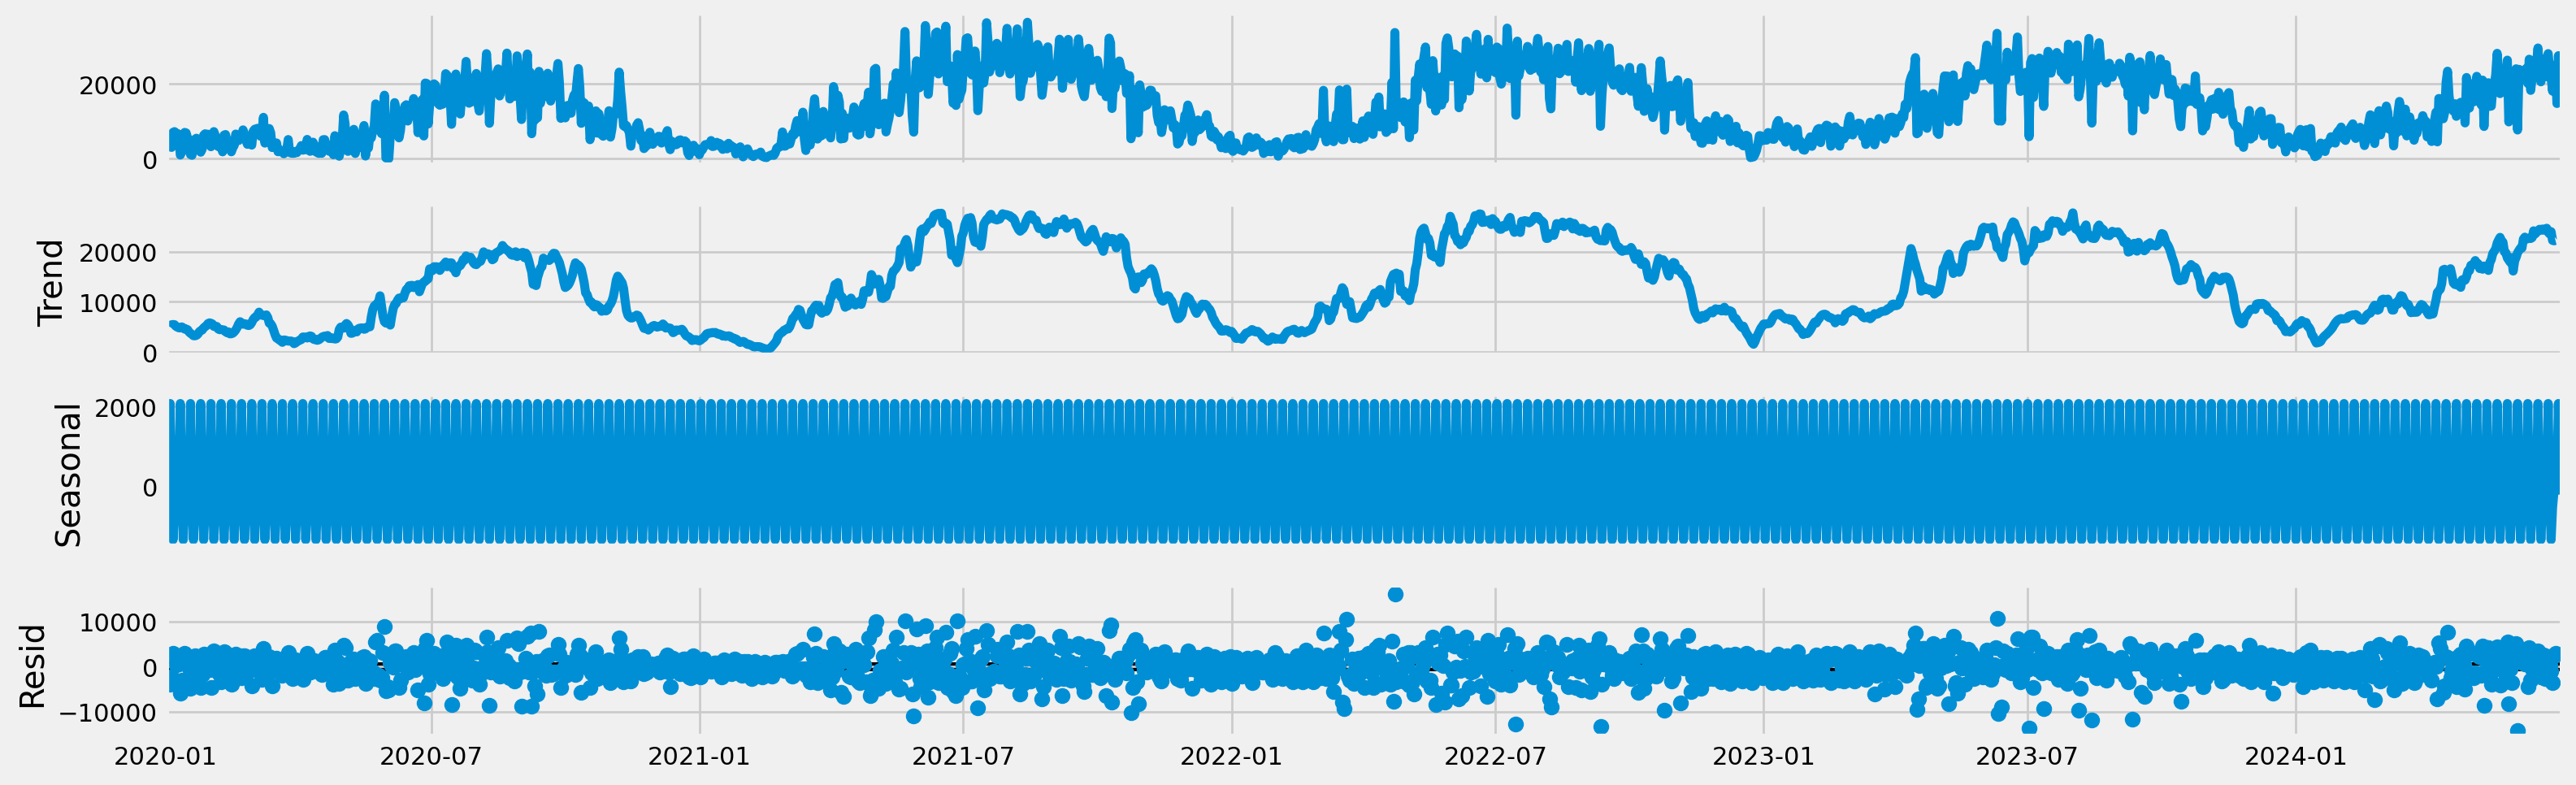

In [354]:
dd = dd.set_index('date')
result = seasonal_decompose(dd, model='additive')
result.plot()
plt.show()

In [273]:
df = data.resample('ME', on='started_at').size().reset_index()

In [274]:
df.columns = ['date', 'rides']
df.head()

,date,rides
0,2020-01-31,142634
1,2020-02-29,137681
2,2020-03-31,138901
3,2020-04-30,83662
4,2020-05-31,197519


In [275]:
df.shape

(54, 2)

Identify trend and seasonality (additive|multiplicative) by ploting the time series.

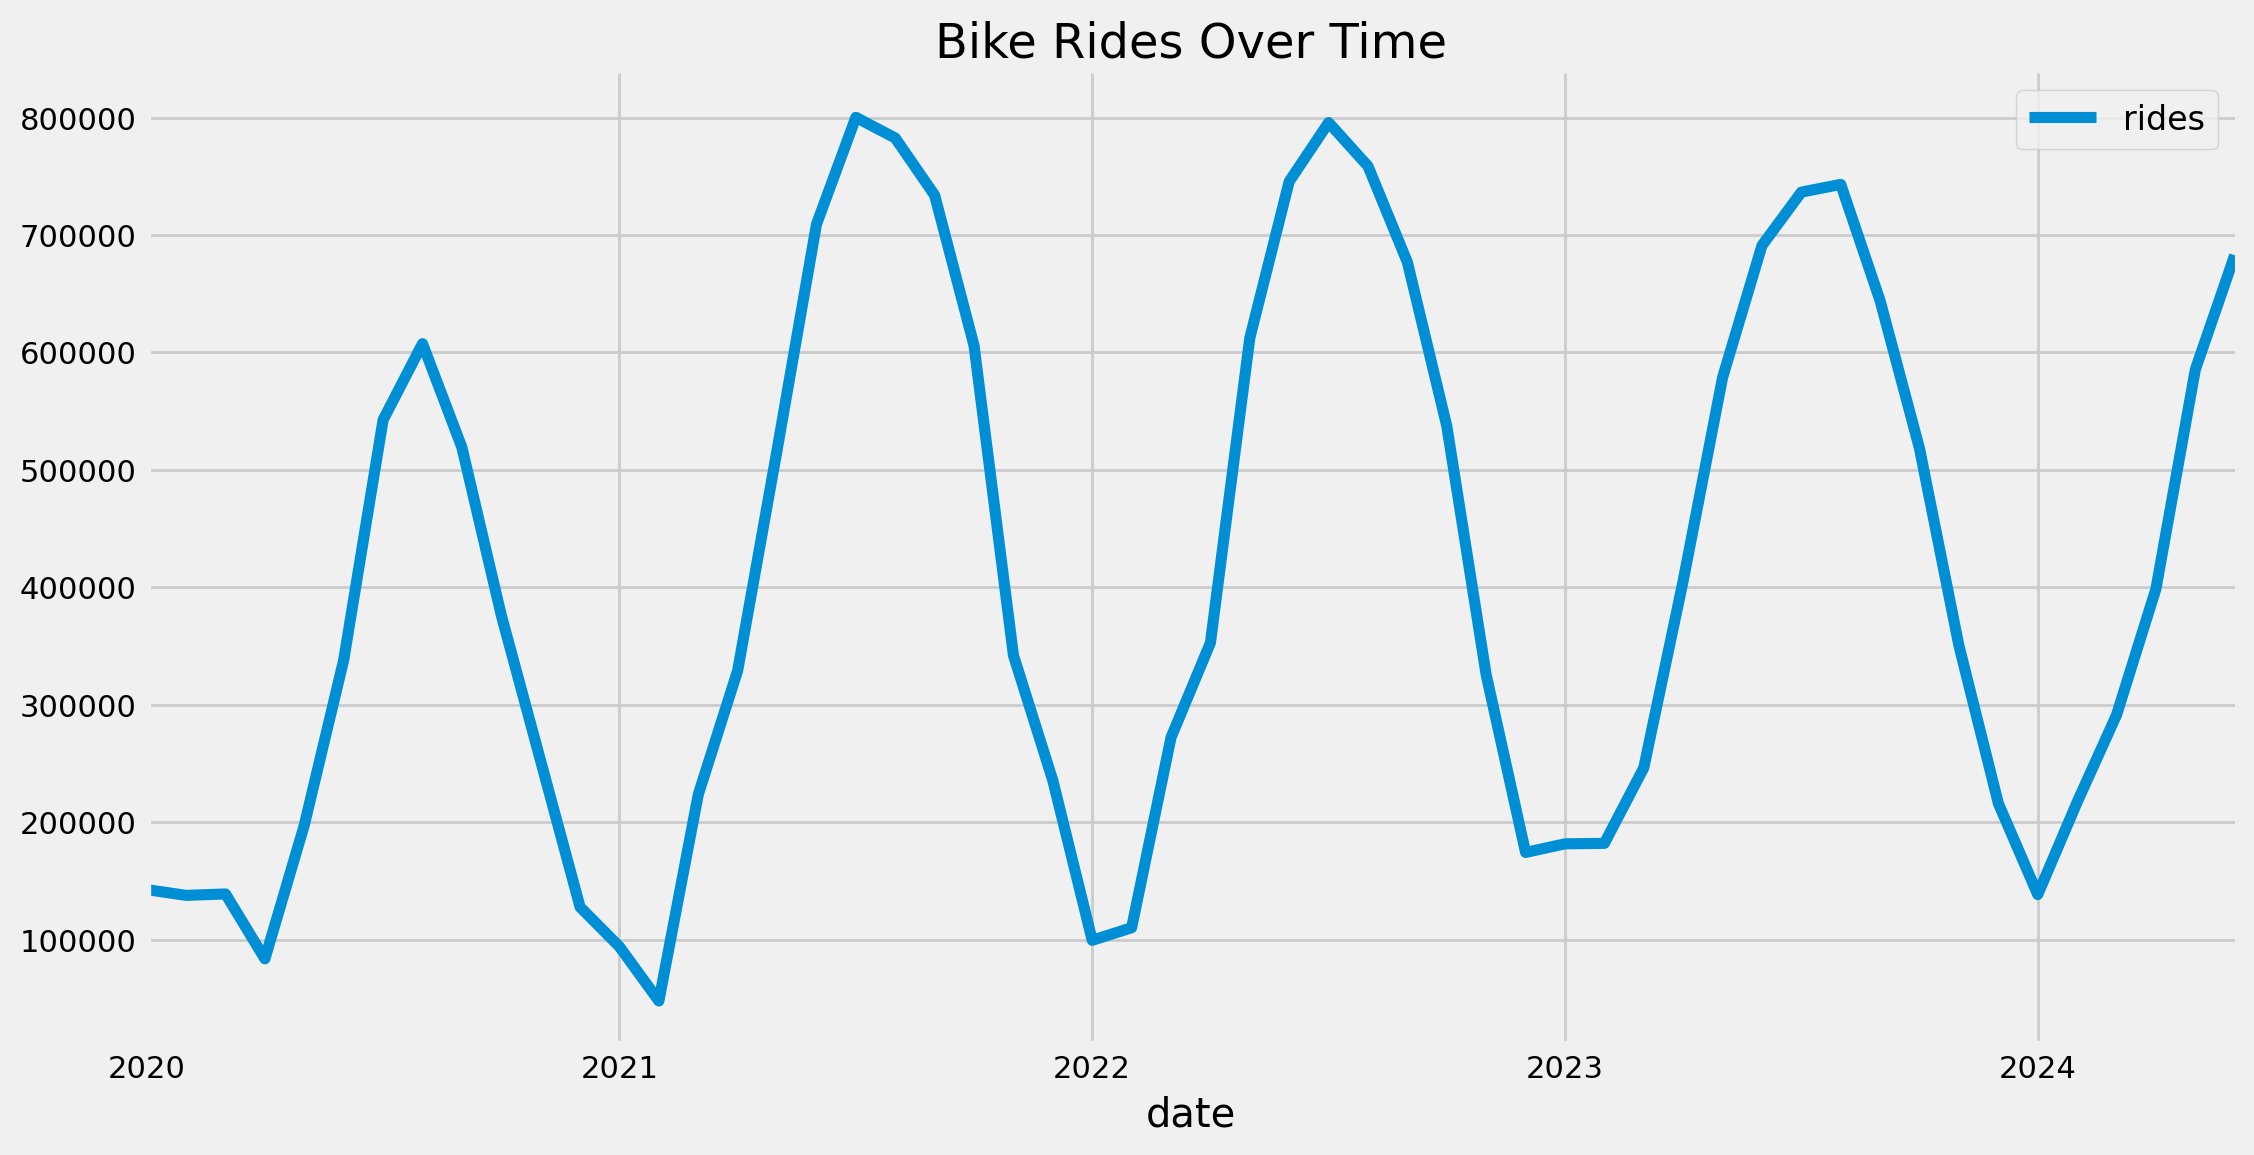

In [332]:
df.plot(figsize=(12, 6))
plt.title('Bike Rides Over Time')
plt.show()

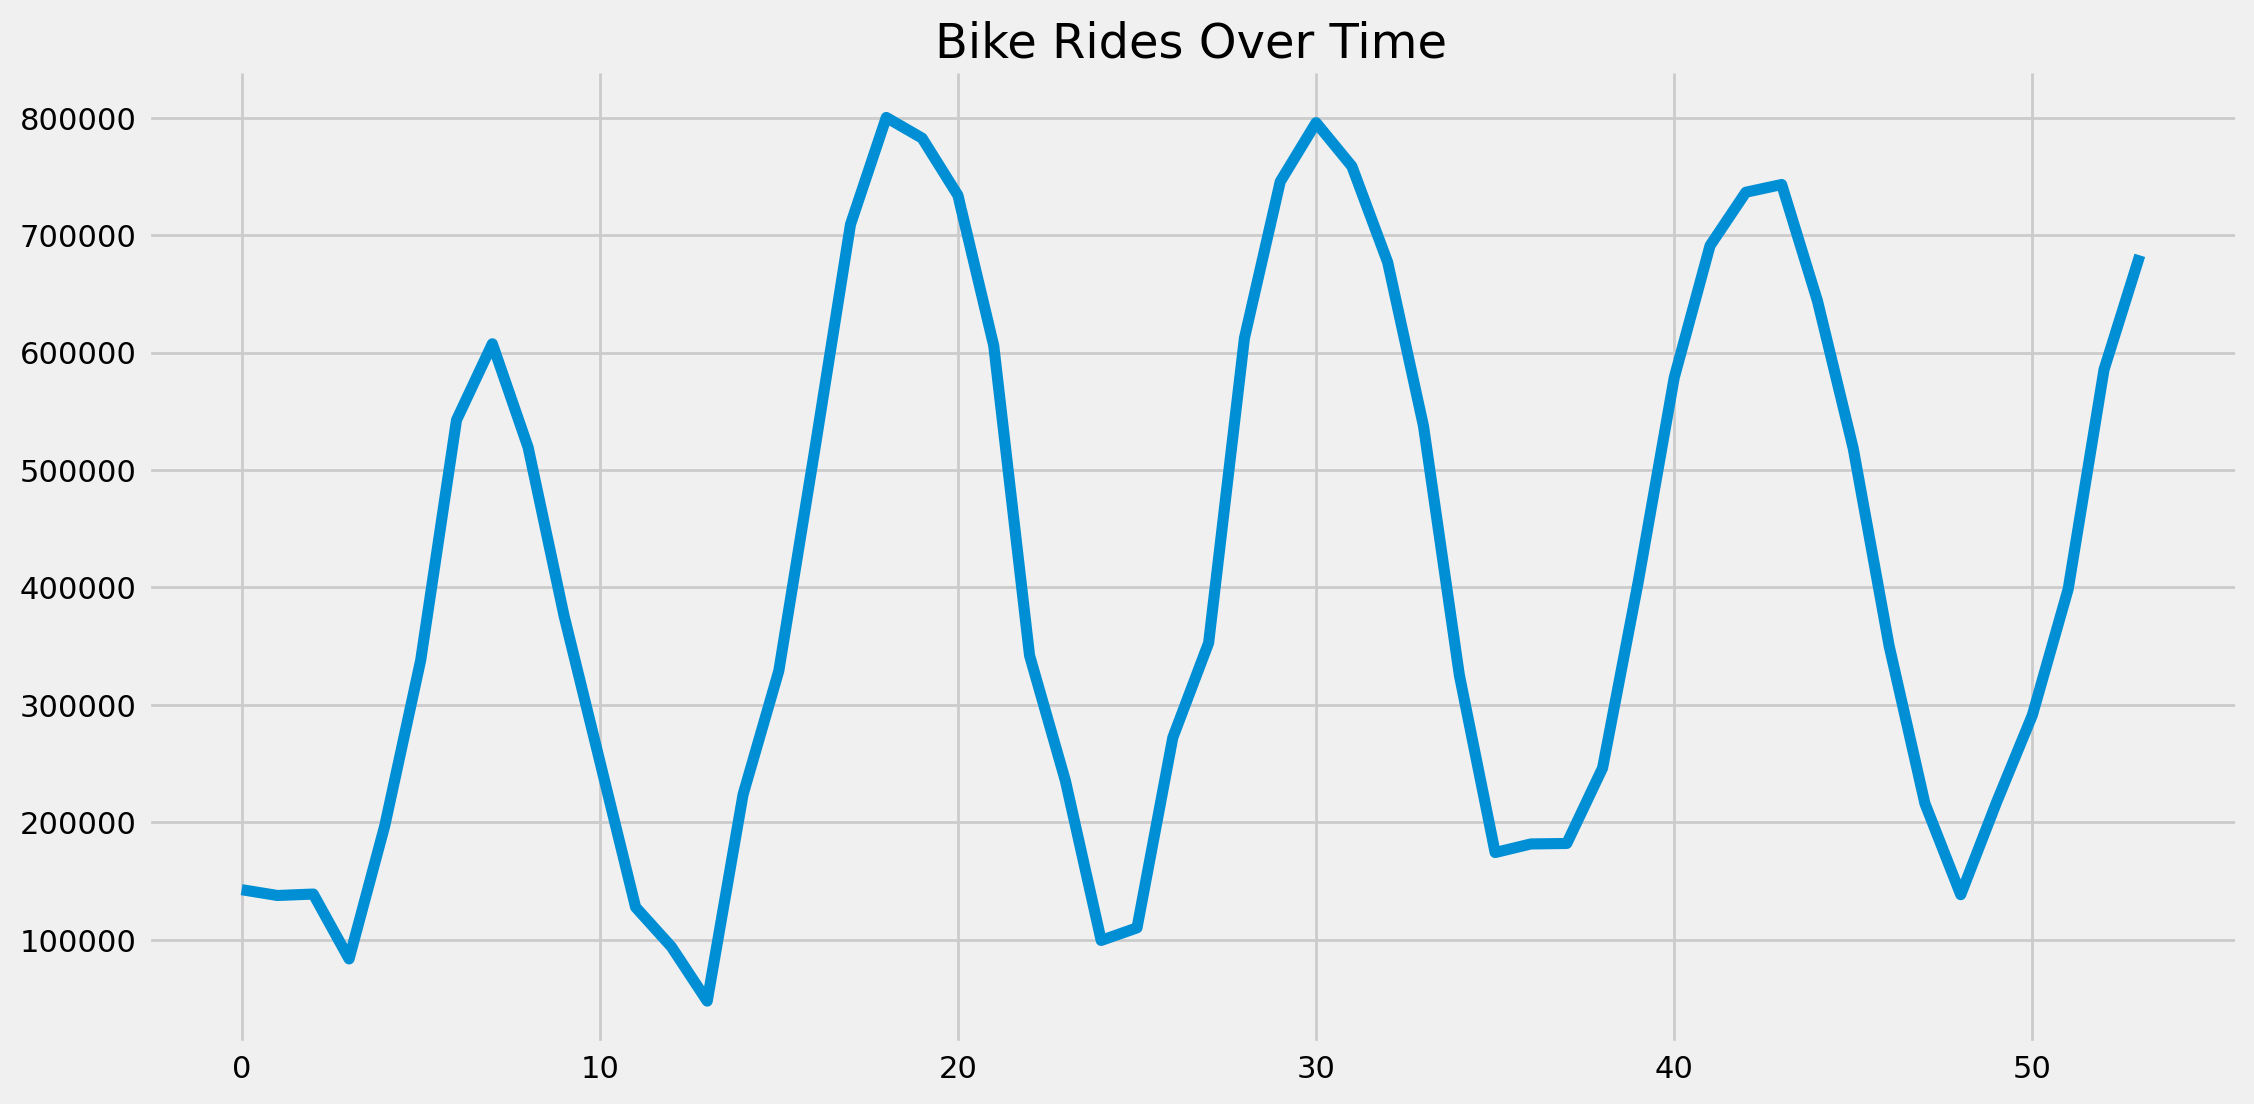

In [276]:
df['rides'].plot(figsize=(12, 6))
plt.title('Bike Rides Over Time')
plt.show()

In [277]:
df = df.set_index('date')

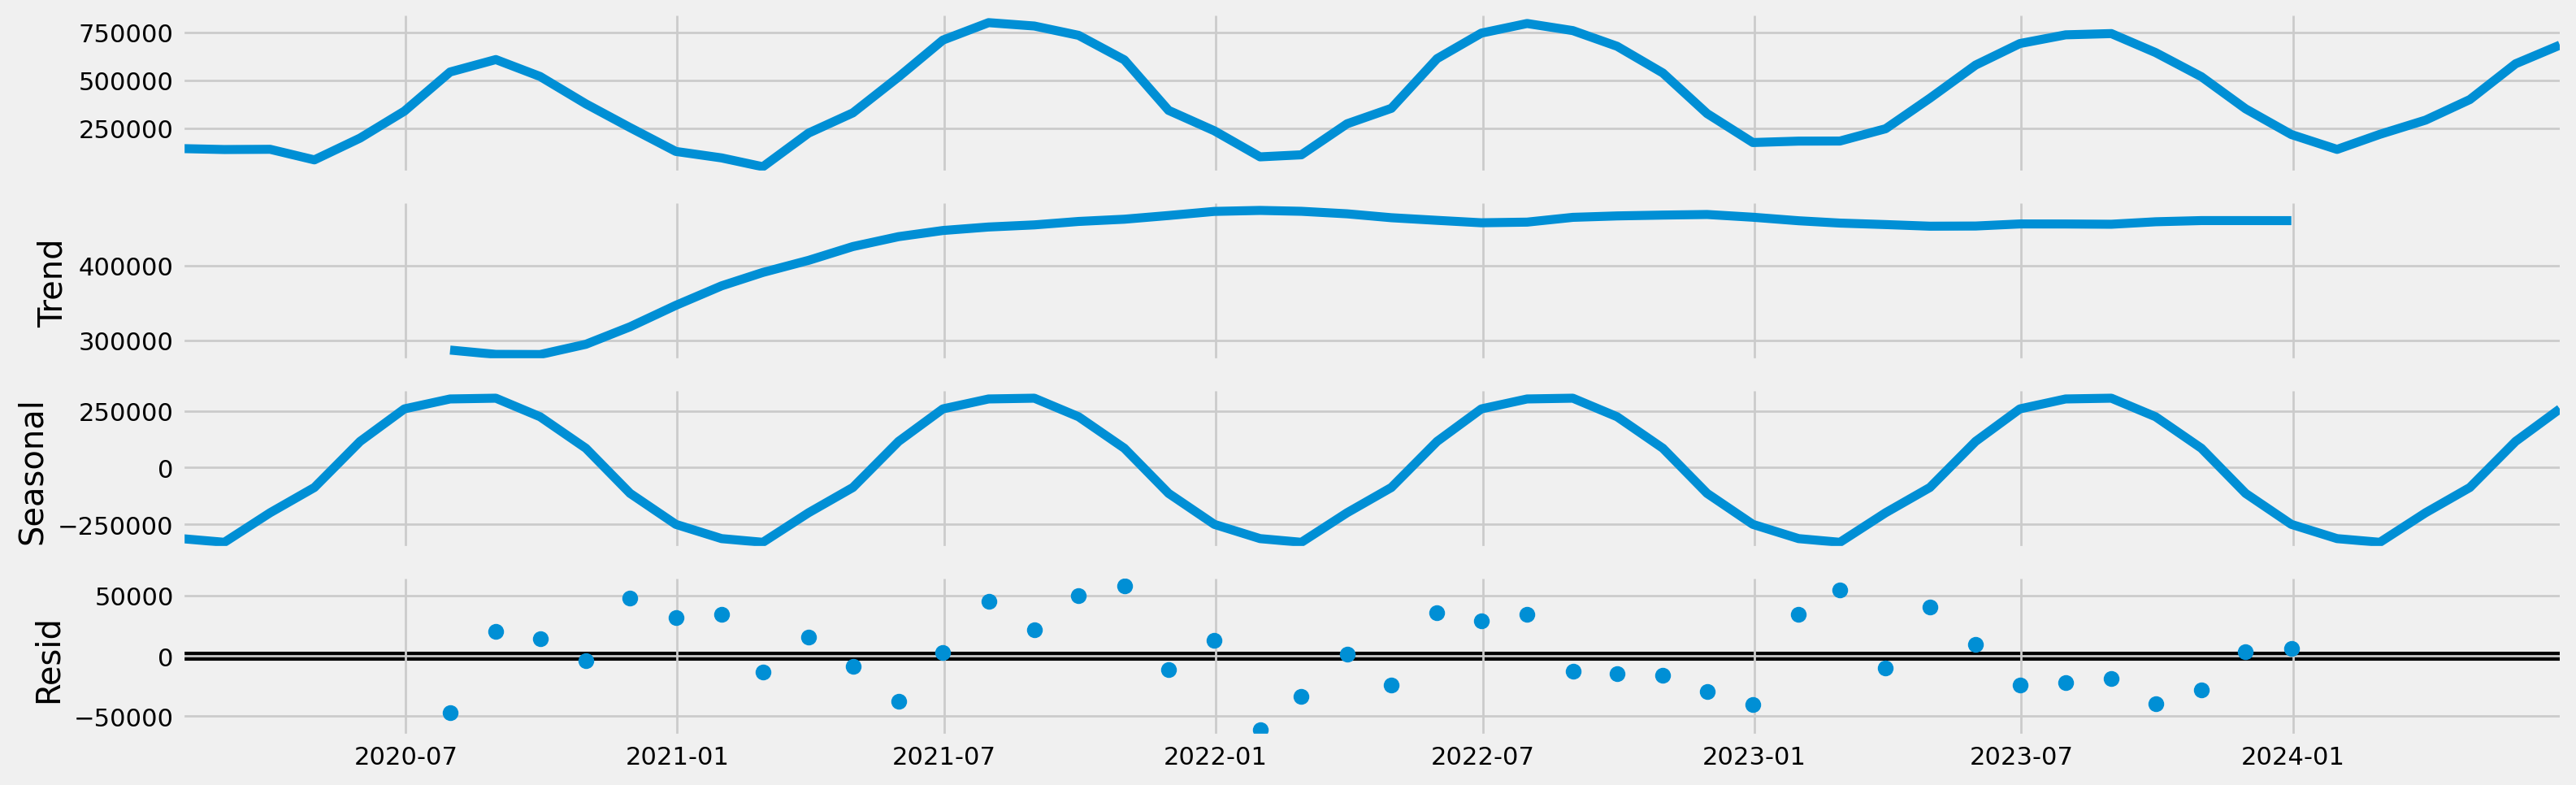

In [280]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df, model='additive')
result.plot()
plt.show()

In [153]:
df.index.max()

Timestamp('2024-06-30 00:00:00')

Plot (decompose) the data and answer to 4 questions:
1. Is there a trend?
2. Is there a seasonality? Additive or multiplicative?
3. Does the time series have strustural breaks?
4. Is the time serties stationar?
5. Is there the outliers?

In [331]:
# check for stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['rides'], autolag='AIC')

print(f'ADF Statistics: {result[0]}, p-value = {result[1]}')

ADF Statistics: -1.906666205233833, p-value = 0.32893164524256935


Such as p-value > 0.05, then the time series is non-stationarity. Make it stationarity by diff.

In [155]:
df['rides_diff'] = df['rides'].diff().dropna()
df

,rides,rides_diff
date,,
2020-01-31,142634,NaN
2020-02-29,137681,"-4,953.0000"
2020-03-31,138901,"1,220.0000"
2020-04-30,83662,"-55,239.0000"
2020-05-31,197519,"113,857.0000"
...,...,...
2024-02-29,217049,"78,683.0000"
2024-03-31,291301,"74,252.0000"
2024-04-30,398646,"107,345.0000"


In [157]:
df_diff = df.dropna()
result = adfuller(df_diff['rides_diff'])

print(f'ADF Statistics: {result[0]}, p-value = {result[1]}')

ADF Statistics: -7.733160311614591, p-value = 1.1114635517491206e-11


In [159]:
df_diff

,rides,rides_diff
date,,
2020-02-29,137681,"-4,953.0000"
2020-03-31,138901,"1,220.0000"
2020-04-30,83662,"-55,239.0000"
2020-05-31,197519,"113,857.0000"
2020-06-30,338109,"140,590.0000"
...,...,...
2024-02-29,217049,"78,683.0000"
2024-03-31,291301,"74,252.0000"
2024-04-30,398646,"107,345.0000"


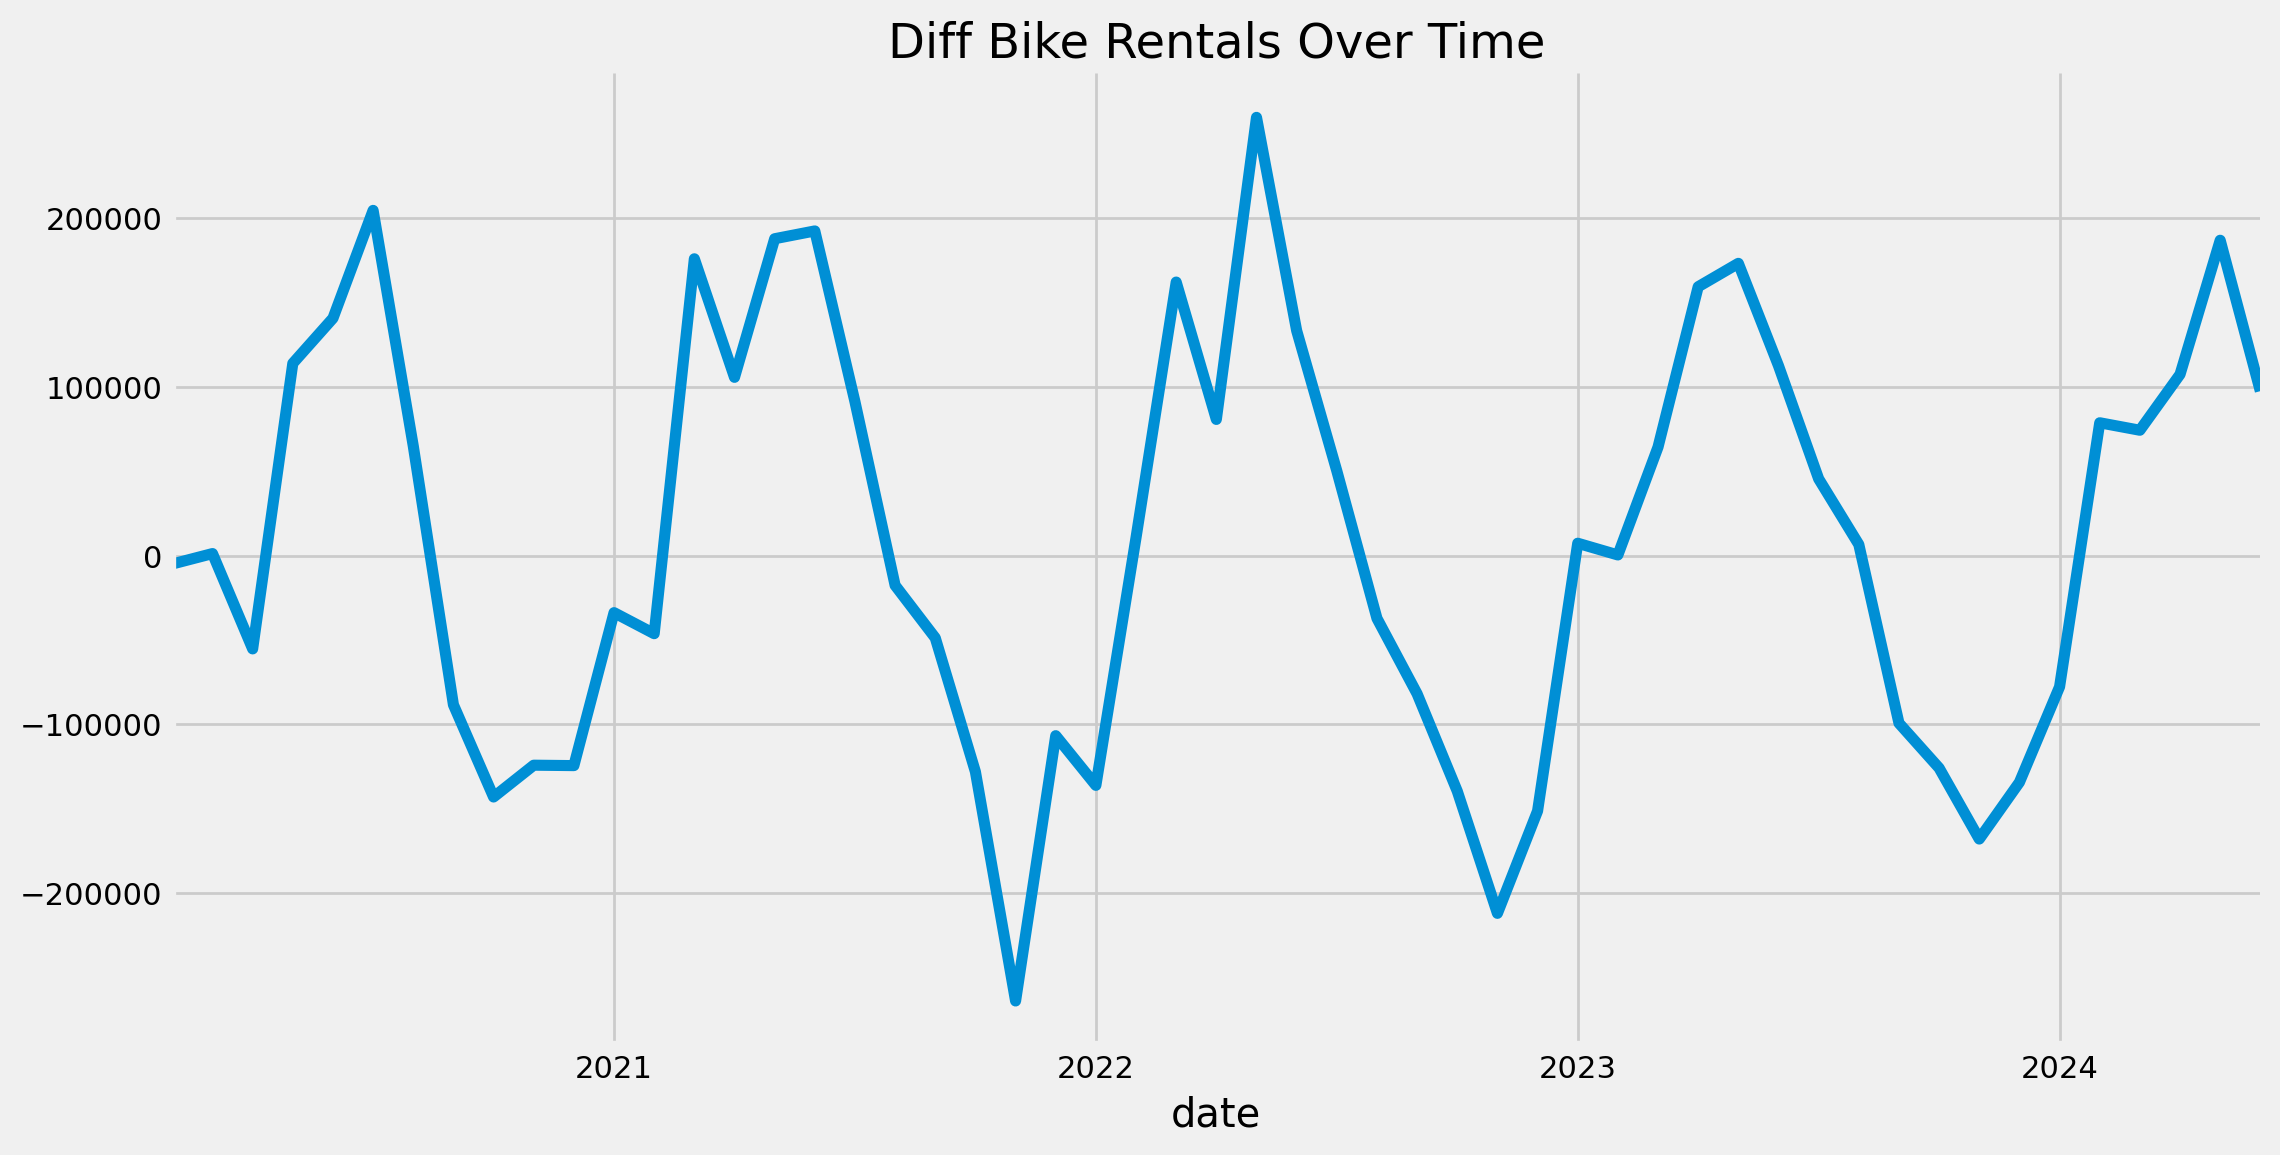

In [160]:
# stationarity
df_diff['rides_diff'].plot(figsize=(12, 6))
plt.title('Diff Bike Rentals Over Time')
plt.show()

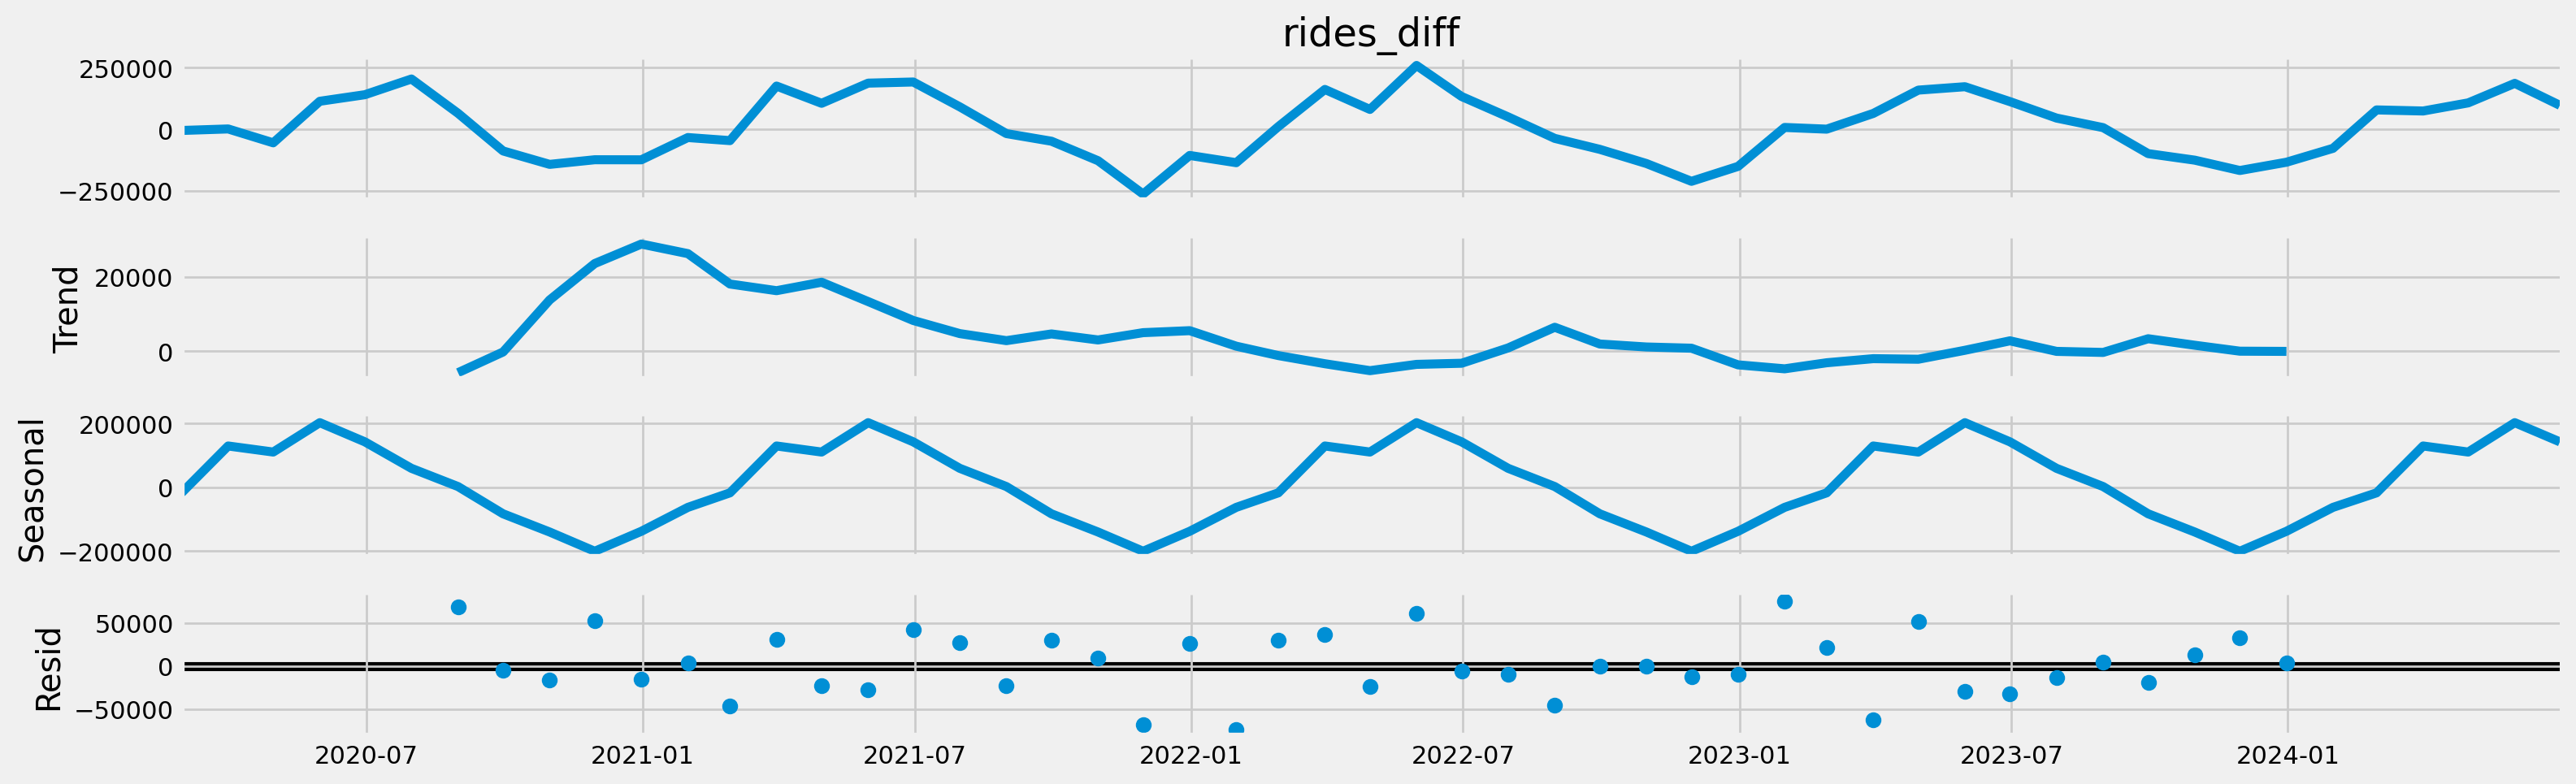

In [161]:
result = seasonal_decompose(df_diff['rides_diff'], model='additive')
result.plot()
plt.show()

In [323]:
X = df.reset_index()['date'].values.reshape(-1, 1)
y = df['rides'].values

model = LinearRegression()
model.fit(X, y)
trend_line = model.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(df.index, y, label='Оригинальные данные')
plt.plot(df.index, trend_line, label='Линейный тренд', color='red')
plt.title('Определение стабильного тренда с помощью линейной регрессии')
plt.legend()
plt.show()

UFuncTypeError: ufunc 'matmul' did not contain a loop with signature matching types (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>) -> None

In [196]:
new_dates = pd.date_range('2024-06-30', '2025-06-30', freq='ME')
new_dates

DatetimeIndex(['2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31',
               '2025-06-30'],
              dtype='datetime64[ns]', freq='ME')

In [196]:
new_dates = pd.date_range('2024-06-30', '2025-06-30', freq='ME')
new_dates

DatetimeIndex(['2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31',
               '2025-06-30'],
              dtype='datetime64[ns]', freq='ME')

In [197]:
df_diff.index

DatetimeIndex(['2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30',
               '2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31',
               '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
               '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
               '2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31',
               '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31',
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
               '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30'],
              dtype='datetime64[ns]', name='dat

In [198]:
new_dates = np.hstack((df_diff.index, new_dates))
new_dates

array(['2020-02-29T00:00:00.000000000', '2020-03-31T00:00:00.000000000',
       '2020-04-30T00:00:00.000000000', '2020-05-31T00:00:00.000000000',
       '2020-06-30T00:00:00.000000000', '2020-07-31T00:00:00.000000000',
       '2020-08-31T00:00:00.000000000', '2020-09-30T00:00:00.000000000',
       '2020-10-31T00:00:00.000000000', '2020-11-30T00:00:00.000000000',
       '2020-12-31T00:00:00.000000000', '2021-01-31T00:00:00.000000000',
       '2021-02-28T00:00:00.000000000', '2021-03-31T00:00:00.000000000',
       '2021-04-30T00:00:00.000000000', '2021-05-31T00:00:00.000000000',
       '2021-06-30T00:00:00.000000000', '2021-07-31T00:00:00.000000000',
       '2021-08-31T00:00:00.000000000', '2021-09-30T00:00:00.000000000',
       '2021-10-31T00:00:00.000000000', '2021-11-30T00:00:00.000000000',
       '2021-12-31T00:00:00.000000000', '2022-01-31T00:00:00.000000000',
       '2022-02-28T00:00:00.000000000', '2022-03-31T00:00:00.000000000',
       '2022-04-30T00:00:00.000000000', '2022-05-31

In [199]:
df2 = pd.DataFrame({'date': new_dates})
df2

,date
0,2020-02-29
1,2020-03-31
2,2020-04-30
3,2020-05-31
4,2020-06-30
...,...
61,2025-02-28
62,2025-03-31
63,2025-04-30
64,2025-05-31


In [200]:
df3 = pd.merge(df, df2, on='date', how='right')
df3

,date,rides,rides_diff
0,2020-02-29,"137,681.0000","-4,953.0000"
1,2020-03-31,"138,901.0000","1,220.0000"
2,2020-04-30,"83,662.0000","-55,239.0000"
3,2020-05-31,"197,519.0000","113,857.0000"
4,2020-06-30,"338,109.0000","140,590.0000"
...,...,...,...
61,2025-02-28,NaN,NaN
62,2025-03-31,NaN,NaN
63,2025-04-30,NaN,NaN
64,2025-05-31,NaN,NaN


In [201]:
df3.tail(13)

,date,rides,rides_diff
53,2024-06-30,"682,820.0000","97,409.0000"
54,2024-07-31,NaN,NaN
55,2024-08-31,NaN,NaN
56,2024-09-30,NaN,NaN
57,2024-10-31,NaN,NaN
58,2024-11-30,NaN,NaN
59,2024-12-31,NaN,NaN
60,2025-01-31,NaN,NaN
61,2025-02-28,NaN,NaN
62,2025-03-31,NaN,NaN


In [202]:
df3['month_num'] = range(1, len(df3) + 1)
df3.head()

,date,rides,rides_diff,month_num
0,2020-02-29,"137,681.0000","-4,953.0000",1
1,2020-03-31,"138,901.0000","1,220.0000",2
2,2020-04-30,"83,662.0000","-55,239.0000",3
3,2020-05-31,"197,519.0000","113,857.0000",4
4,2020-06-30,"338,109.0000","140,590.0000",5


In [243]:
for x in range(1, 13):
    df3[f'season_{x}'] = np.int64(df3['date'].dt.month == x)

df3.head()

,date,rides,rides_diff,month_num,season_1,season_2,season_3,season_4,season_5,season_6,season_7,season_8,season_9,season_10,season_11,season_12
0,2020-02-29,"137,681.0000","-4,953.0000",1,0,1,0,0,0,0,0,0,0,0,0,0
1,2020-03-31,"138,901.0000","1,220.0000",2,0,0,1,0,0,0,0,0,0,0,0,0
2,2020-04-30,"83,662.0000","-55,239.0000",3,0,0,0,1,0,0,0,0,0,0,0,0
3,2020-05-31,"197,519.0000","113,857.0000",4,0,0,0,0,1,0,0,0,0,0,0,0
4,2020-06-30,"338,109.0000","140,590.0000",5,0,0,0,0,0,1,0,0,0,0,0,0


In [204]:
season_columns = [f'season_{x}' for x in range(2, 13)]
season_columns

['season_2',
 'season_3',
 'season_4',
 'season_5',
 'season_6',
 'season_7',
 'season_8',
 'season_9',
 'season_10',
 'season_11',
 'season_12']

In [249]:
X = df3[['month_num'] + season_columns]
X.columns

Index(['month_num', 'season_2', 'season_3', 'season_4', 'season_5', 'season_6',
       'season_7', 'season_8', 'season_9', 'season_10', 'season_11',
       'season_12'],
      dtype='object')

In [250]:
y = df3['rides_diff'].reset_index()['rides_diff']
y

0     -4,953.0000
1      1,220.0000
2    -55,239.0000
3    113,857.0000
4    140,590.0000
         ...     
61            NaN
62            NaN
63            NaN
64            NaN
65            NaN
Name: rides_diff, Length: 66, dtype: float64

In [251]:
X1 = X[X.index < 54]
y1 = y[y.index < 54]

In [252]:
X1.dtypes

month_num    int64
season_2     int64
season_3     int64
season_4     int64
season_5     int64
season_6     int64
season_7     int64
season_8     int64
season_9     int64
season_10    int64
season_11    int64
season_12    int64
dtype: object

In [281]:
X1.drop(columns=['month_num_2'], inplace=True)

In [286]:
X.drop(columns=['month_num_2'], inplace=True)

In [294]:
import statsmodels.api as sm
X1.loc[:, 'month_num_2'] = X1['month_num'] ** 2
X1 = sm.add_constant(X1)
model = sm.OLS(y1, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rides_diff   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     18.74
Date:                Thu, 22 Aug 2024   Prob (F-statistic):           4.93e-13
Time:                        15:05:17   Log-Likelihood:                -656.80
No. Observations:                  54   AIC:                             1342.
Df Residuals:                      40   BIC:                             1369.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.407e+04   3.64e+04     -2.311      0.026   -1.58e+05   -1.05e+04
month_num    2185.1388   1991.395      1.097      0.279   -1839.620    6209.898
season_2     7.227e+04   3.64e+04      1.985      0.054   -1309.701    1.46e+05
season_3     1.598e+05   3.64e+04      4.396      0.000    8.64e+04    2.33e+05
season_4     1.437e+05   3.63e+04      3.955      0.000    7.03e+04    2.17e+05
season_5     2.483e+05   3.63e+04      6.836      0.000    1.75e+05    3.22e+05
season_6     1.954e+05   3.53e+04      5.528      0.000    1.24e+05    2.67e+05
season_7     1.585e+05   3.82e+04      4.150      0.000    8.13e+04    2.36e+05
season_8     6.457e+04   3.82e+04      1.692      0.098   -1.25e+04    1.42e+05
season_9    -1.936e+04   3.81e+04     -0.508      0.614   -9.64e+04    5.77e+04
season_10   -7.404e+04   3.81e+04     -1.943      0.059   -1.51e+05    2984.495
season_11   -1.319e+05   3.81e+04     -3.463      0.001   -2.09e+05   -5.49e+04
season_12   -6.915e+04   3.81e+04     -1.815      0.077   -1.46e+05    7830.458
month_num_2   -38.4480     35.338     -1.088      0.283    -109.869      32.973
==============================================================================
Omnibus:                        0.501   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.778   Jarque-Bera (JB):                0.110
Skew:                           0.079   Prob(JB):                        0.947
Kurtosis:                       3.154   Cond. No.                     1.78e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [208]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X1, y1)

LinearRegression()

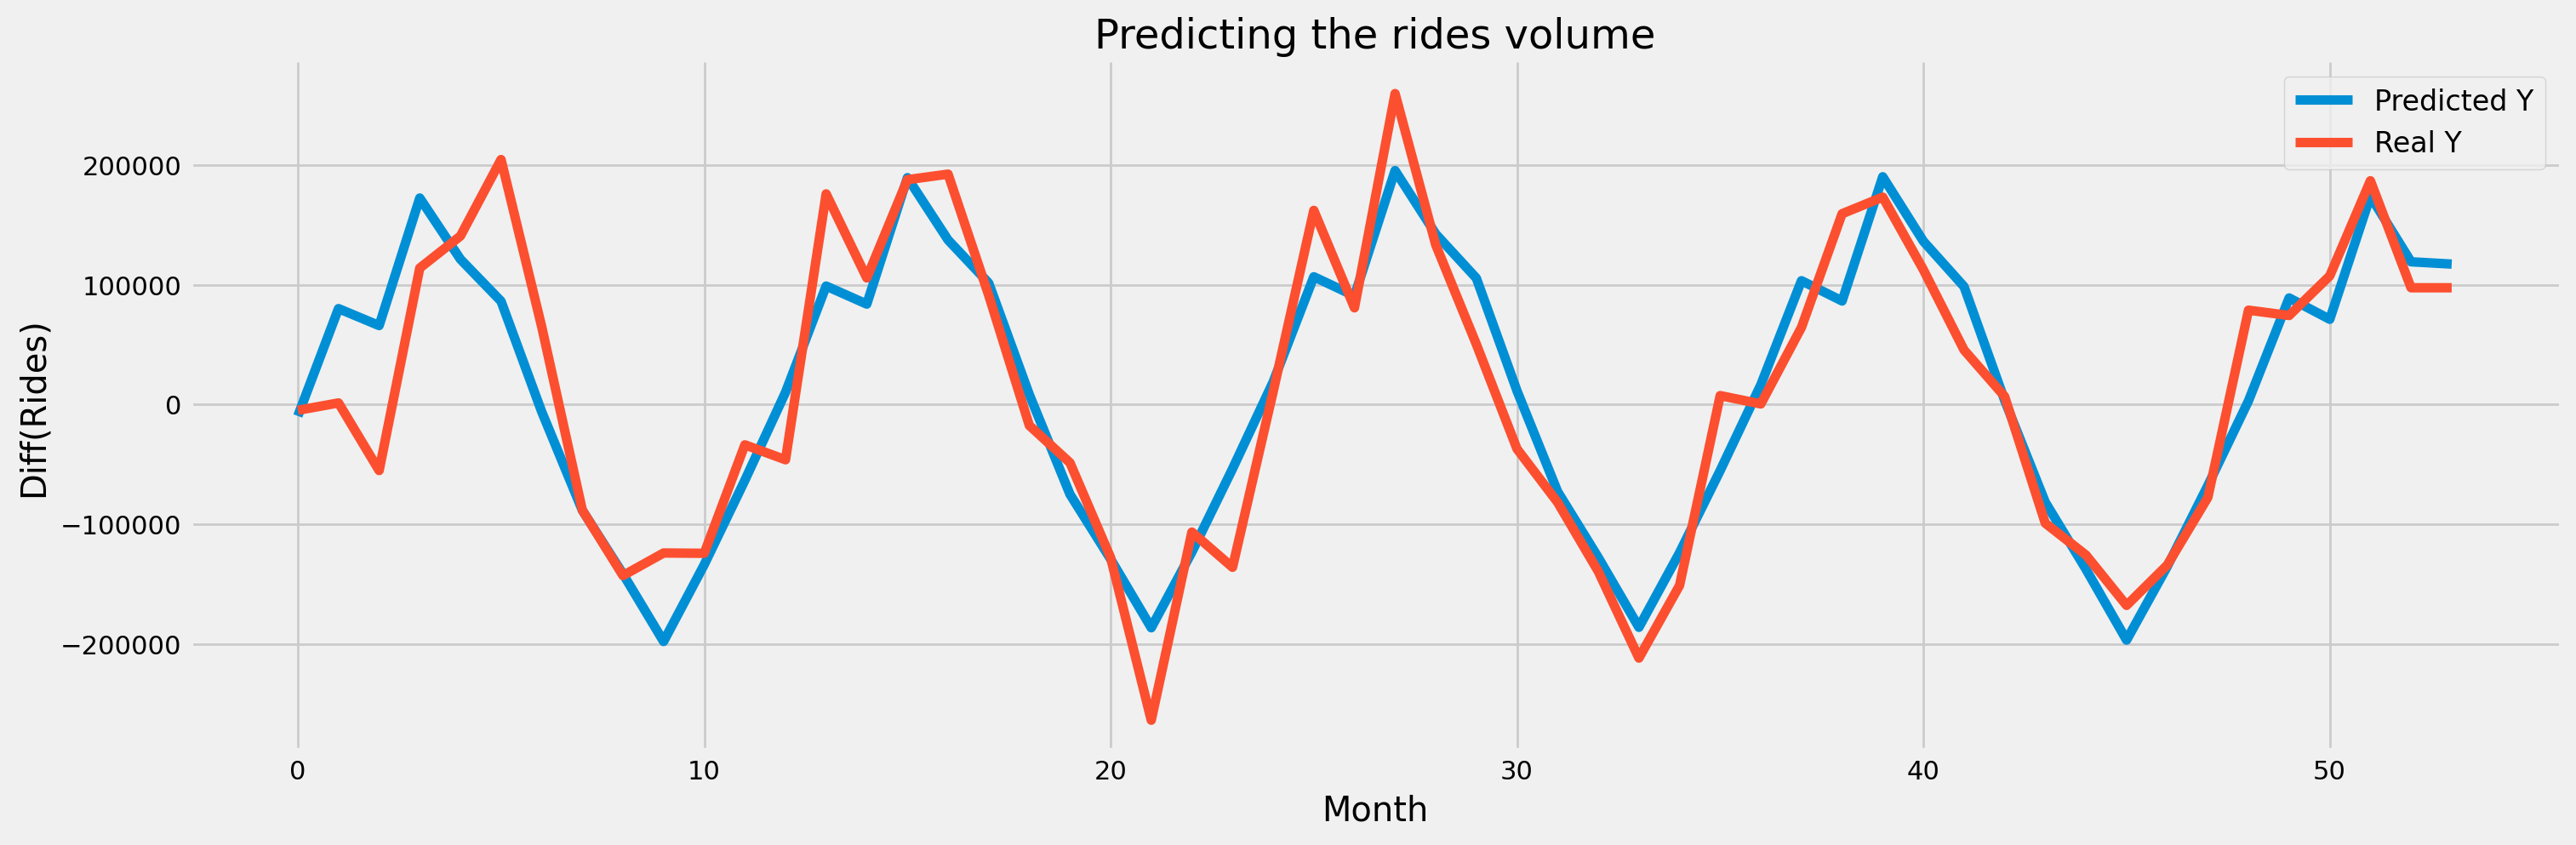

In [295]:
y_pred = model.predict(X1) 
pred = pd.DataFrame({'Predicted Y': y_pred, 'Real Y': y1})
pred.plot()
plt.title('Predicting the rides volume')
plt.xlabel('Month')
plt.ylabel('Diff(Rides)');

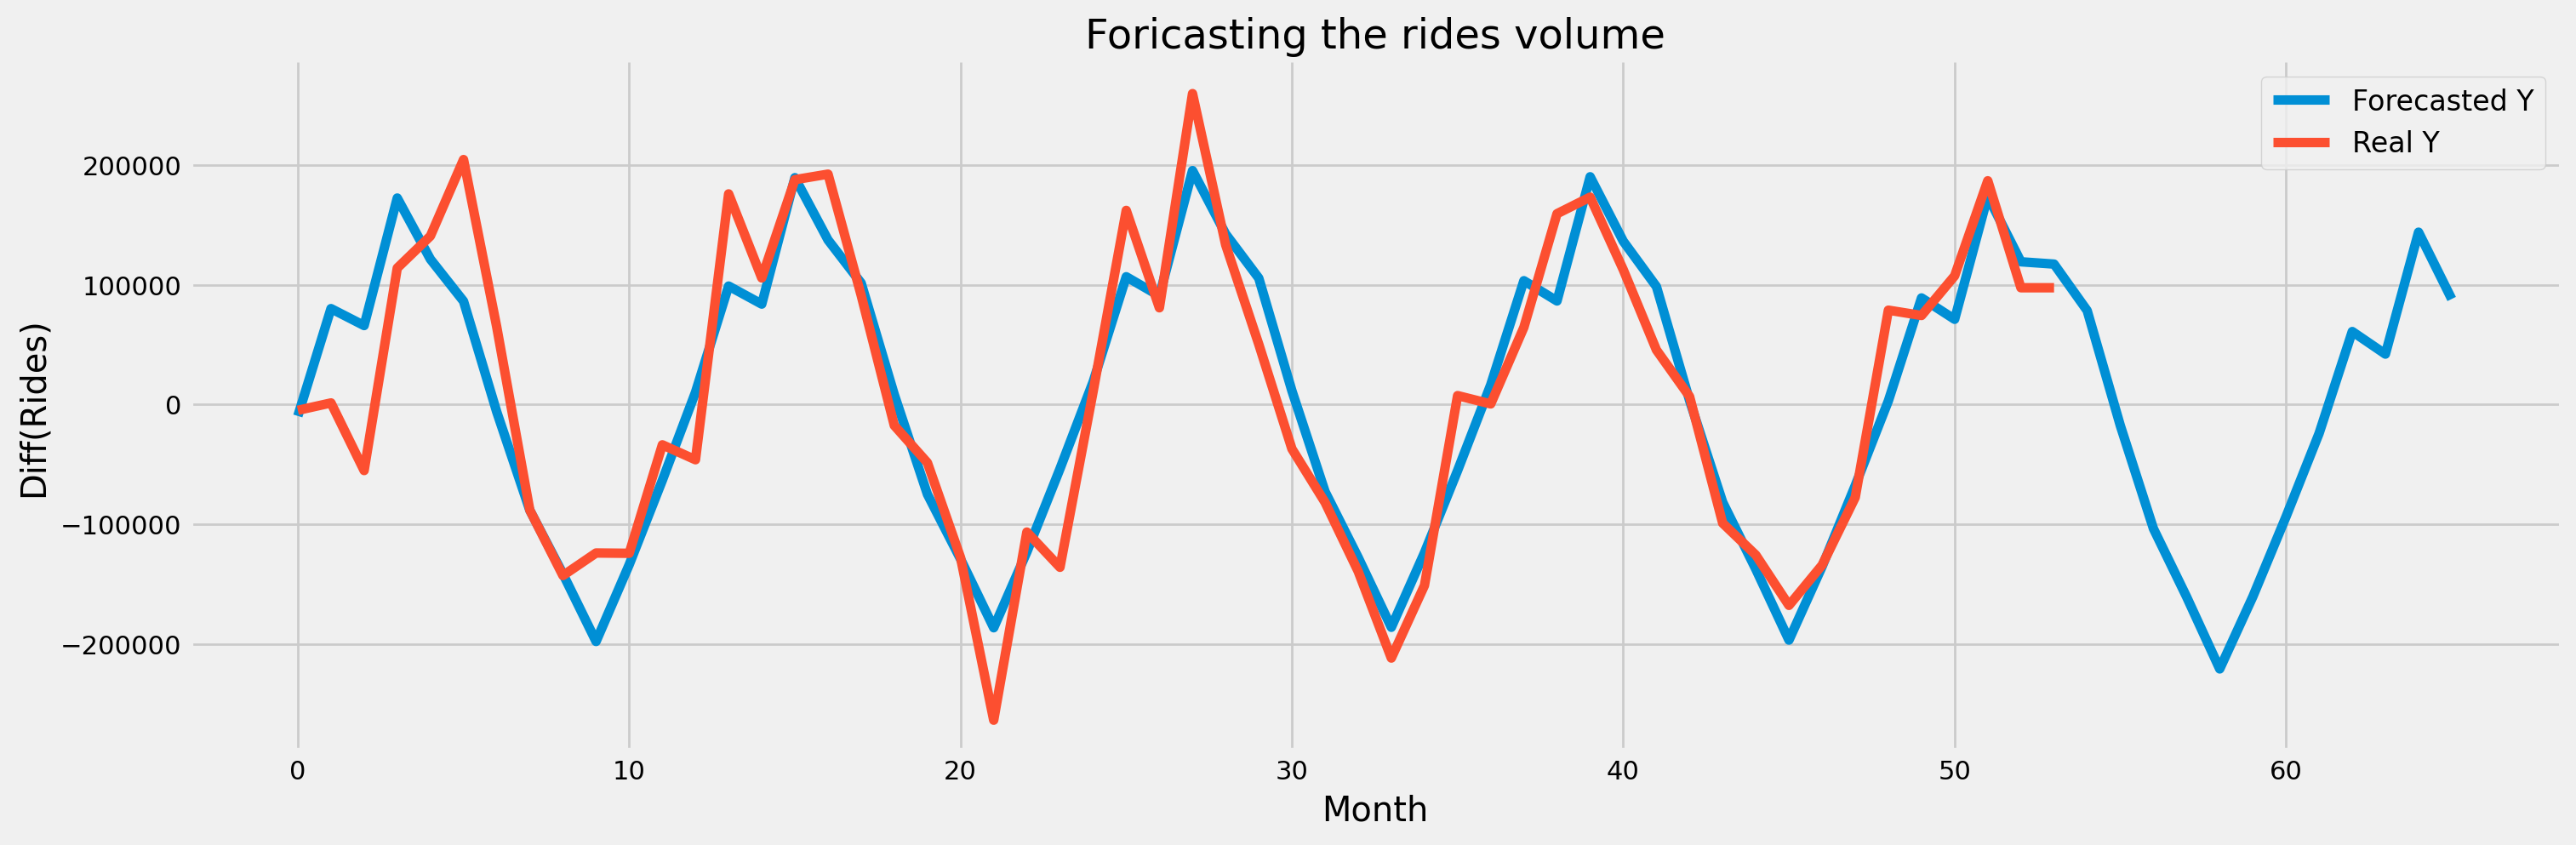

In [296]:
X.loc[:, 'month_num_2'] = X['month_num'] ** 2
X = sm.add_constant(X)
y_forecast = model.predict(X)
forecast = pd.DataFrame({'Forecasted Y': y_forecast, 'Real Y': y})
forecast.plot()
plt.title('Foricasting the rides volume')
plt.xlabel('Month')
plt.ylabel('Diff(Rides)');

In [297]:
y_forecast

0     -9,656.9561
1     79,989.3478
2     65,831.0517
3    172,344.9556
4    121,246.7768
         ...     
61   -24,119.1482
62    60,836.5000
63    41,987.5481
64   143,810.7962
65    88,021.9616
Length: 66, dtype: float64

In [298]:
first_value = df.iloc[0, 0]
first_value

np.int64(142634)

In [299]:
forecast_original = np.r_[first_value, y_forecast].cumsum()
forecast_original

array([142634.        , 132977.04390131, 212966.39171294, 278797.44343488,
       451142.39906713, 572389.17585969, 658552.23671841, 652468.17550987,
       564059.24223406, 422496.68689098, 224491.50948065,  90656.46000304,
        27271.28845817,  37376.73387071, 136205.73123841, 219953.68056127,
       409292.78183928, 546610.95232244, 647922.6549166 , 656064.48348834,
       580958.68803766, 451776.51856456, 265228.97506904, 141928.80755109,
        88155.76601072, 106950.58947261, 213546.21293449, 304138.03639637,
       499398.25985826, 641714.80057014, 747102.12143786, 758396.816328  ,
       685521.13524056, 557646.32817555, 371483.39513295, 247645.08611278,
       192411.15111503, 208822.32916437, 312111.55525856, 398474.22939758,
       588582.55158146, 724824.43906016, 823214.35473956, 826588.89248622,
       744870.30230014, 607229.83418133, 410378.48812978, 274929.01414549,
       207161.16222847, 210115.67140339, 299025.47666799, 370085.97802228,
       543969.37546625, 6

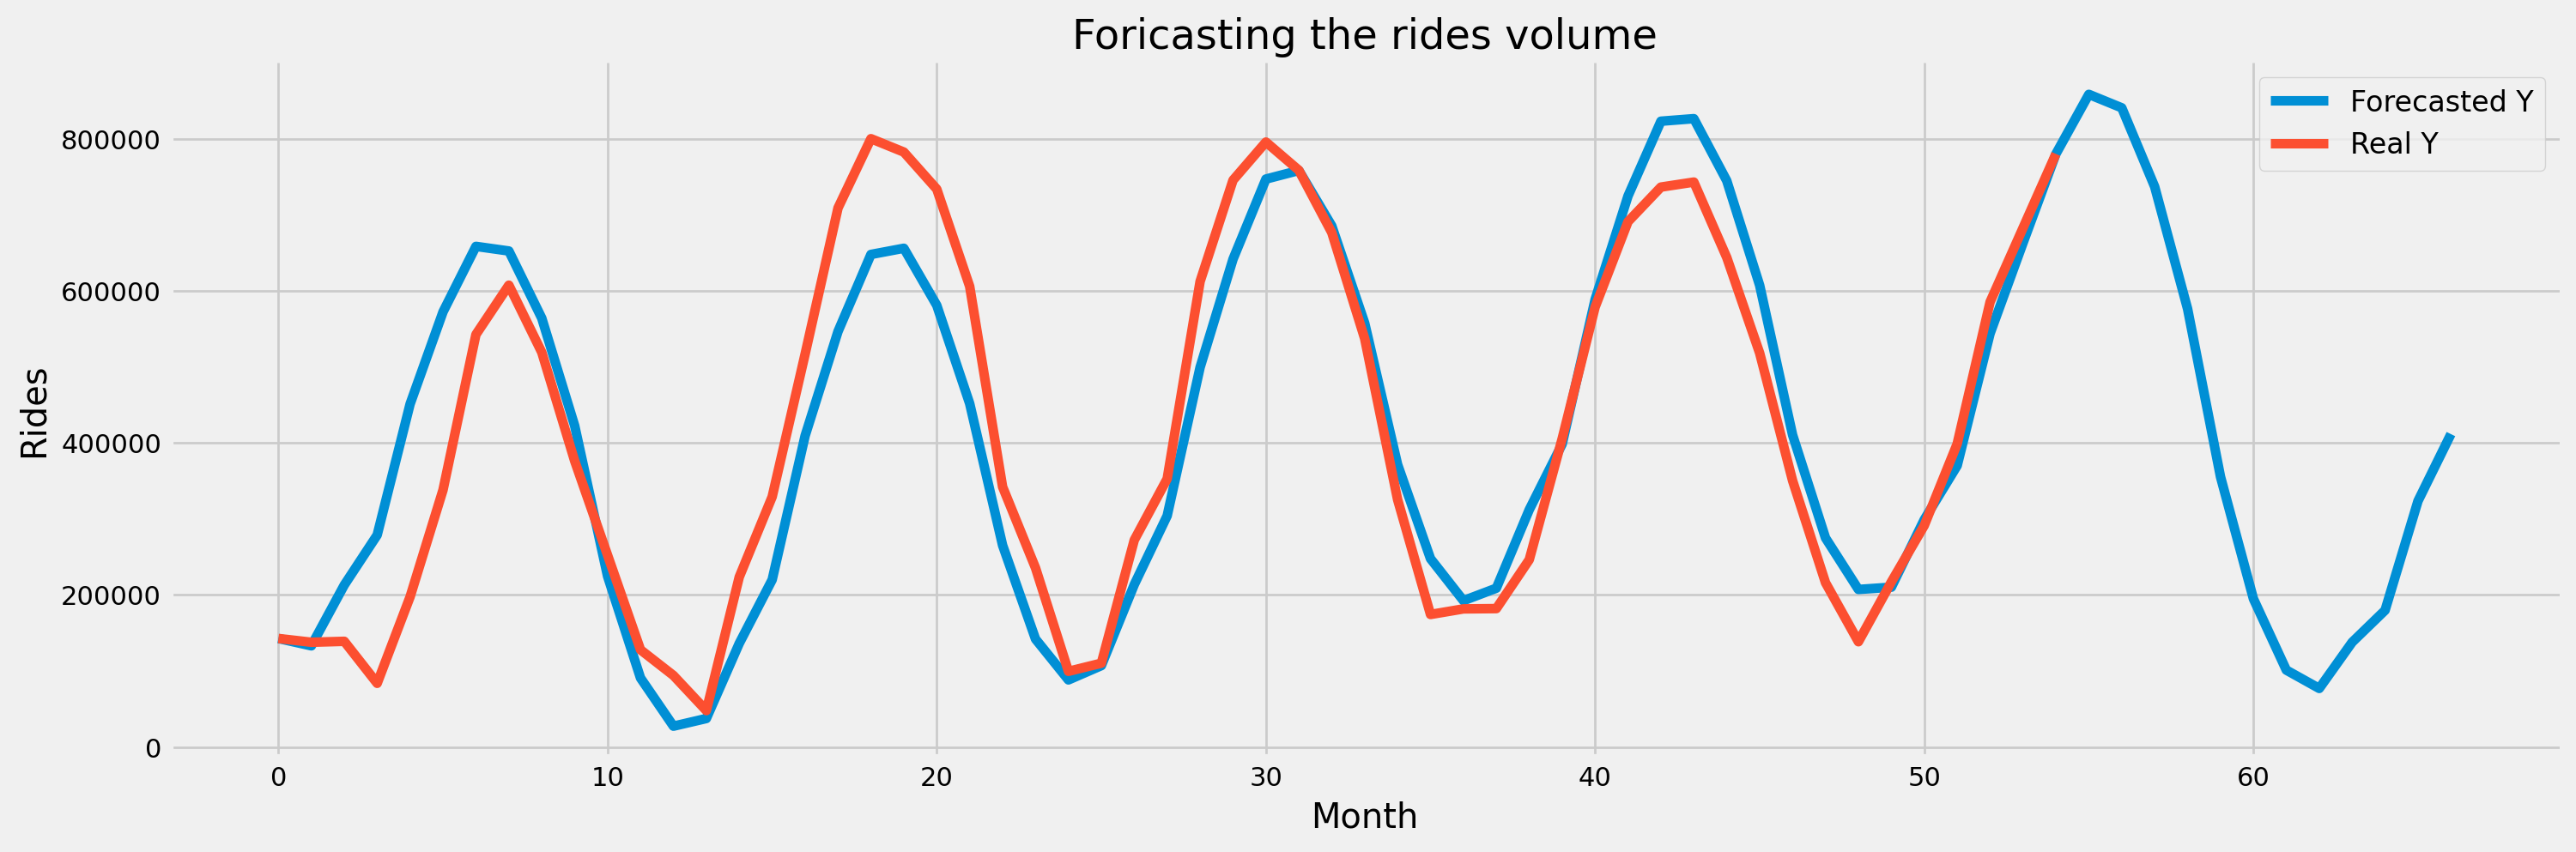

In [300]:
# apply 
forecast = pd.DataFrame({'Forecasted Y': forecast_original, 'Real Y': np.r_[first_value, y].cumsum()})
forecast.plot()
plt.title('Foricasting the rides volume')
plt.xlabel('Month')
plt.ylabel('Rides');

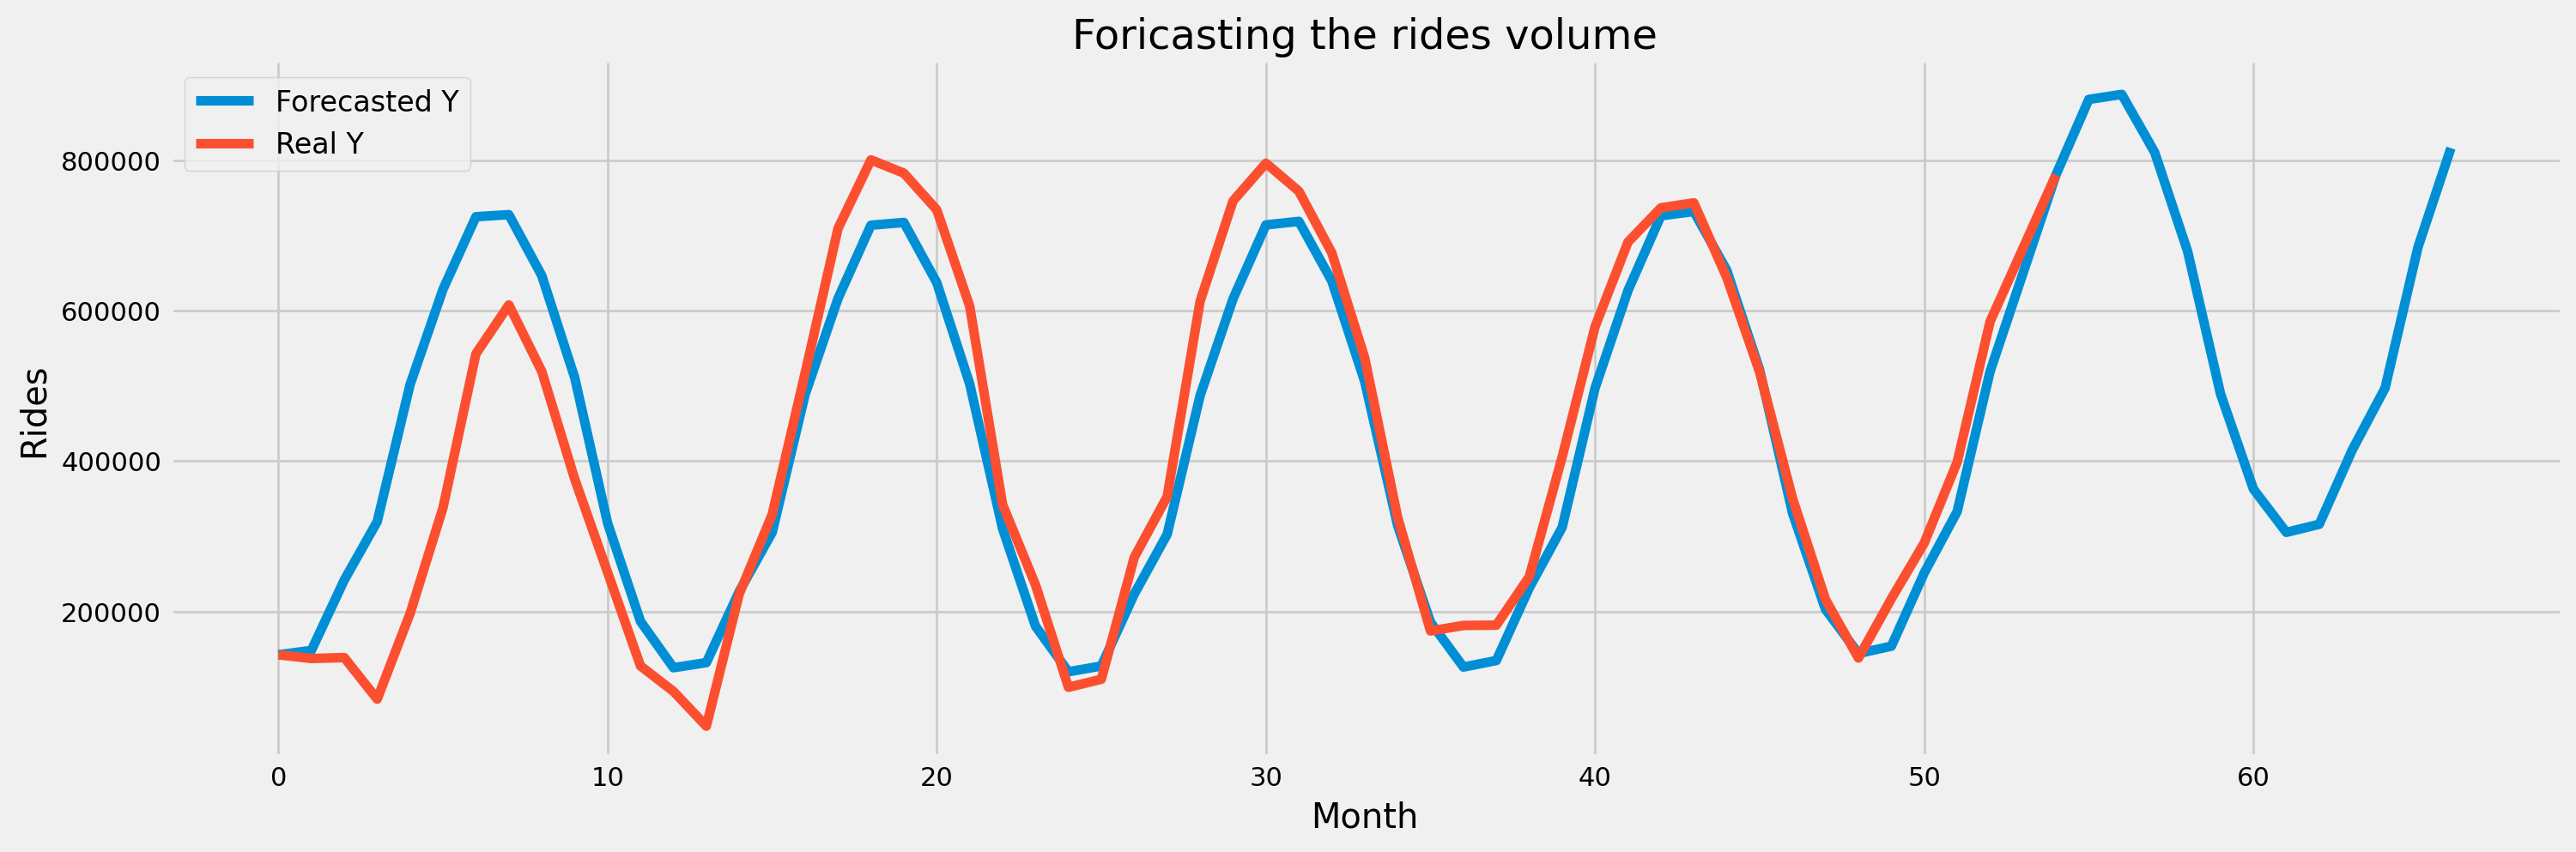

In [293]:
# apply 
forecast = pd.DataFrame({'Forecasted Y': forecast_original, 'Real Y': np.r_[first_value, y].cumsum()})
forecast.plot()
plt.title('Foricasting the rides volume')
plt.xlabel('Month')
plt.ylabel('Rides');

In [234]:
forecast_original[55:]

array([880569.00509376, 887277.76018752, 810277.51528129, 678739.52037506,
       489374.77546883, 362796.0305626 , 305283.03565637, 316020.93851022,
       414559.64136406, 497094.54421792, 684297.84707177, 815871.46537002])

In [238]:
pd.DataFrame({'date': pd.date_range('2024-06-30', '2025-06-30', freq='MS'),
              'rides': np.int64(forecast_original[55:])})

,date,rides
0,2024-07-01,880569
1,2024-08-01,887277
2,2024-09-01,810277
3,2024-10-01,678739
4,2024-11-01,489374
5,2024-12-01,362796
6,2025-01-01,305283
7,2025-02-01,316020
8,2025-03-01,414559
9,2025-04-01,497094


### Save the Data <a name='save-data'></a>

In [19]:
# save processed dataset for modeling

# filename = '../00_data/02_processed/used_cars_data_processed_final.pkl'
# pickle.dump(data, open(filename, 'wb'))

# %store myvar # to store dataset


---
\
[__<< Exploratory Data Analysis__](./03_XXX_exploratory_data_analysis.ipynb) | [__Home__](../README.md) | [__Modeling >>__](./05_XXX_modeling.ipynb)

\
\
[PROJECT NAME], _[MMMM YYYY]_